In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def load_data(country, data_lis):
    df = pd.read_csv('owid-covid-data.csv')
    df = df[df['location'].isin([country])]
    if data_lis != None:
        df = df.filter(items=data_lis)

    for column in df.columns.values:
        df[column] = df[column].fillna(0)
        
    return df
    
def add_rows(df, num_rows, fill):
    df = df.reset_index()
    df = df.drop(['index'], axis=1)
    rows = {}
    for column in df.columns.values:
        rows[column] = [fill for _ in range(num_rows)]
    rows = pd.DataFrame(rows) 
    df = pd.concat([rows, df], ignore_index=True)
    df = df.reset_index()
    return df


In [3]:
columns = ['date', 'total_cases', 'total_deaths', 'total_tests', 'total_vaccinations']
days_offset = 3
df = load_data('Canada', None)

dates = df['date']

df = df.drop(['date', 'iso_code', 'continent', 'location', 'tests_units'], axis=1)

targets = df['total_cases']
features = df.drop(['total_cases'], axis=1)

features = add_rows(features, days_offset, 0)
future_x = features[-days_offset:]
features = features[:-days_offset]

train_x, test_x, train_y, test_y = train_test_split(features, targets, test_size=0.2, random_state=43)
print('Data and data split info:')
print('------------------------')
print(f'size of training data: {train_y.size}')
print(f'size of testing data:  {test_y.size}')
print(f'number of features:    {len(test_x.columns.values)}')
print('------------------------')

Data and data split info:
------------------------
size of training data: 710
size of testing data:  178
number of features:    62
------------------------


In [4]:
lr = LinearRegression()
lr.fit(train_x, train_y)
coefficients = pd.concat([pd.DataFrame(train_x.columns),pd.DataFrame(np.transpose(lr.coef_))], keys=['name','value'], axis = 1)
coefficients.columns = coefficients.columns.droplevel(1)
coefficients = coefficients.sort_values('value')

print('coefficients:')
print('------------------------')
print(coefficients.to_string())

coefficients:
------------------------
                                          name        value
41  new_people_vaccinated_smoothed_per_hundred -2516871.112
8               new_cases_smoothed_per_million -1531184.981
16                   hosp_patients_per_million  -548573.616
11             new_deaths_smoothed_per_million  -365578.887
14                    icu_patients_per_million  -141536.265
3                                 total_deaths   -54764.068
37         people_fully_vaccinated_per_hundred   -53607.203
27                               positive_rate   -24961.762
38                  total_boosters_per_hundred   -22548.508
1                                    new_cases   -20144.917
4                                   new_deaths    -7419.666
39       new_vaccinations_smoothed_per_million      -60.204
25                          new_tests_smoothed      -33.822
28                              tests_per_case      -33.715
42                            stringency_index      -33.688
0

In [5]:
#used to generate a large number of predictions for algerithm verification
pred_y = lr.predict(test_x)

results = pd.DataFrame(pred_y, index=test_y.index, columns = ['pred'])
results['real'] = test_y
results['index'] = test_y.index
results.sort_values('index')


print('Analysis of regression')
print('------------------------')
print(f'Score: {lr.score(features, targets)}')
print(f'R squared: {metrics.r2_score(test_y, pred_y)}')
print(f'Mean error: {metrics.mean_absolute_error(test_y, pred_y)} cases')
print('------------------------')

Analysis of regression
------------------------
Score: 0.9999746757931892
R squared: 0.9999726896454993
Mean error: 3057.015806166927 cases
------------------------


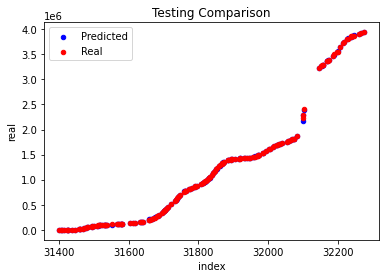

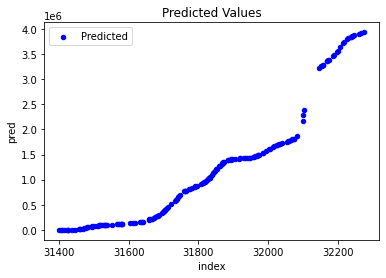

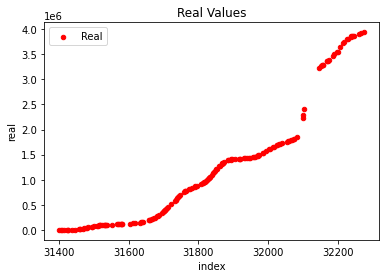

In [6]:
ax = plt.gca()
results.plot(kind='scatter', x='index', y='pred', color='blue', label='Predicted', ax=ax)
results.plot(kind='scatter', x='index', y='real', color='red', label='Real', ax=ax)
plt.legend(loc="upper left")
plt.title('Testing Comparison')
plt.show()

ax = plt.gca()
results.plot(kind='scatter', x='index', y='pred', color='blue', label='Predicted', ax=ax)
plt.title('Predicted Values')
plt.show()

ax = plt.gca()
results.plot(kind='scatter', x='index', y='real', color='red', label='Real', ax=ax)
plt.title('Real Values')
plt.show()

In [7]:
future_y = lr.predict(future_x)


for i in range(days_offset):
    print(f'Predicted cases {i+1} days after {dates.tolist()[-1]}: {int(future_y[-i])}')

Predicted cases 1 days after 2022-06-28: 3931640
Predicted cases 2 days after 2022-06-28: 3935835
Predicted cases 3 days after 2022-06-28: 3932369
